# Práctica 2: Procesamiento del Lenguaje Natural

__Fecha de entrega: 8 de mayo de 2023__

El objetivo de esta práctica es aplicar los conceptos teóricos vistos en clase en el módulo de PLN. La práctica consta de 2 notebooks que se entregarán simultáneamente en la tarea de entrega habilitada en el Campus  Virtual.

Lo más importante en esta práctica no es el código Python, sino el análisis de los datos y modelos que construyas y las explicaciones razonadas de cada una de las decisiones que tomes. __No se valorarán trozos de código o gráficas sin ningún tipo de contexto o explicación__.

Finalmente, recuerda establecer el parámetro `random_state` en todas las funciones que tomen decisiones aleatorias para que los resultados sean reproducibles (los resultados no varíen entre ejecuciones).

In [1]:
RANDOM_STATE = 333

# Apartado 1: Análisis de sentimientos con word embeddings


__Nombres de los estudiantes: Enrique Queipo de Llano Burgos y Alejandro Paz Olalla__

## 1) Carga del conjunto de datos

El fichero `IMBD_Dataset.csv` contiene opiniones de películas clasificadas en 2 categorías diferentes (positiva/negativa).

Este set de datos se creó utilizando el "IMDB Dataset of 50K Movie Reviews", el cual contiene 50,000 reseñas de películas con un sentimiento positivo o negativo adjunto a ellas.

Muestra un ejemplo de cada clase.

Haz un estudio del conjunto de datos. ¿qué palabras aparecen más veces?, ¿tendría sentido normalizar de alguna manera el corpus?

Crea una partición de los datos dejando el 80% para entrenamiento y el 20% restante para test usando la función `train_test_split` de sklearn.


In [2]:
# acceso a google drive

#from google.colab import drive
#drive.mount('/content/drive')
#!pip uninstall keras --yes
#!pip install --upgrade pip
#!pip uninstall tensorflow --yes
#!pip install tensorflow
#!pip install numpy==1.22

In [36]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import re
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

In [4]:
imbd_file = 'IMDB_Dataset.csv'

df=pd.read_csv(imbd_file)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [6]:
df.shape

(50000, 2)

In [7]:
positive = df[df['sentiment'] == 'positive'].sample(random_state=RANDOM_STATE)
positive_index = positive.index.values
negative = df[df['sentiment'] == 'negative'].sample(random_state=RANDOM_STATE)
negative_index = negative.index.values
print('Positive review: ',positive.values)
print('Negative review: ',negative.values)

Positive review:  [['The minutiae of what\'s involved in carrying out a robbery is what makes this one of the best of all heist movies. Then there\'s the robbery itself, a wordless, thirty minute nail-biter that has never been surpassed, followed by what is probably the cinema\'s most pronounced example of dishonor among thieves as things begin to spectacularly unravel, and we have what is unquestionably the greatest of all heist movies.<br /><br />This was a tough and unsentimental film when it first appeared in 1955 and it is just as tough and unsentimental today. (It displays some of the edgy brutality of Dassin\'s earlier "Brute Force"). There isn\'t a flabby moment or duff performance in the entire film and Dassin captures the milieu of seedy clubs and Parisian back streets like no-one else and the final drive through Paris by a dying man is one of the most iconic closing sequences of any movie. A classic.'
  'positive']]
Negative review:  [["Crude, some times crass - to me that's

positive    25000
negative    25000
Name: sentiment, dtype: int64


<AxesSubplot:xlabel='sentiment', ylabel='count'>

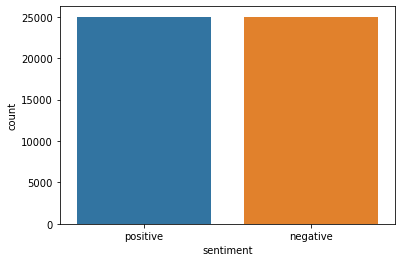

In [8]:
print(df['sentiment'].value_counts())
sns.countplot(x = "sentiment", data = df)

In [9]:
X = df['review']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE,stratify=y)
train_sample = X_train.sample(random_state=RANDOM_STATE)
train_sample_index = train_sample.index.values
print('Review ', train_sample_index, train_sample.values)

Review  [29064] ["I'm surprised to read all the positive comments on this movie. Even my 4 and 6 year old were bored. The chipmunks are cute...but the storyline is overly obvious. Not recommended for young ones with the least sophisticated tastes.<br /><br />We did hear a few laughs from the audience while we were in attendance; but I wondered why.<br /><br />I don't admit to ever being a 'chipmunks' fan, but I expected to be entertained. It's not even an 'escapist' movie as far as I can tell. Simply a heavy handed view of 'success too young spoils'. We've seen more than enough of that with Britney Spears, et al, haven't we?<br /><br />Don't bother."]


[Text(0.5, 1.0, 'Distribution of the train set')]

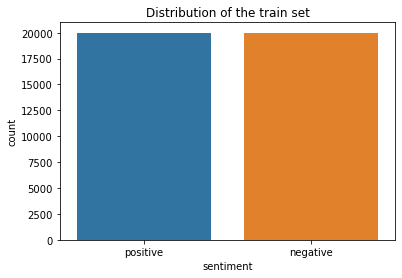

In [10]:
sns.countplot(x=y_train).set(title='Distribution of the train set')

[Text(0.5, 1.0, 'Distribution of the test set')]

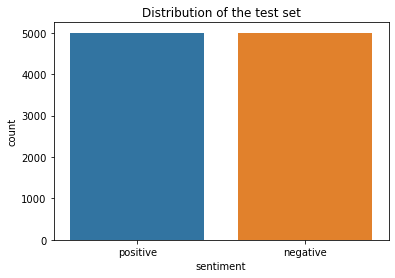

In [11]:
sns.countplot(x=y_test).set(title='Distribution of the test set')

A continuación, codificamos en binario los ``sentiment``. ES NECESARIO ESTO PARA PODER ENTRENAR EL MODELO.

In [12]:
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


Observamos que las distribuciones en los conjuntos de entrenamiento y prueba son prácticamente iguales y no tenemos class imbalance.

A continuación, queremos ver qué palabras son las que más se repiten. Para ello, vectorizaremos el corpus y sumaremos cada fila para calcular cuántas veces aparece cada palabra.

In [13]:
#Primero vectorizamos las reviews
cv = CountVectorizer()
cv_matrix = cv.fit_transform(df['review'])
cv_matrix

<50000x101895 sparse matrix of type '<class 'numpy.int64'>'
	with 6826529 stored elements in Compressed Sparse Row format>

In [14]:
# Nº de veces que aparece cada palabra == suma de su correspondiente columna
# Sacamos las sumas
totales = np.squeeze(np.asarray(np.sum(cv_matrix, axis = 0)))
# Ordenamos y nos quedamos con los 20 mejores índices
top20 = np.argsort(totales)[-20:]
top20

array([ 62917,  64110, 101096,  33226,  13654,  99740,  34443,  60214,
         6166,  98149,  90137,  90455,  44763,  46902,  12041,  46765,
        91217,  63757,   4541,  90160])

In [15]:
# Enseñamos las 20 palabras más repetidas
cv.get_feature_names_out()[top20]

array(['not', 'on', 'you', 'film', 'but', 'with', 'for', 'movie', 'as',
       'was', 'that', 'this', 'in', 'it', 'br', 'is', 'to', 'of', 'and',
       'the'], dtype=object)

Podemos ver que las palabras que más aparecen (como tabmién es de esperar) son preposiciones, pronombres, etc que no aportan mucho a la clasificación del documento, por tanto será importante normalizarlo para eliminar estas stopwords. Este es el caso de palabras como ``this``, ``that``, ``and``, ``you``... o incluso de la notación html para el salto de línea ``br``.

In [16]:
wpt = nltk.WordPunctTokenizer()
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/quiquequeipodellano/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
norm_corpus = normalize_corpus(df['review'])
norm_corpus

array(['one reviewers mentioned watching oz episode youll hooked right exactly happened mebr br first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use wordbr br called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far awaybr br would say main appeal show due fact goes shows wouldnt dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz doesnt mess around first episode ever saw struck nasty surreal couldnt say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards wholl sold nickel inmates wholl kill order get away well ma

In [18]:
#Primero vectorizamos las reviews
cv = CountVectorizer()
cv_matrix = cv.fit_transform(norm_corpus)
cv_matrix

<50000x175583 sparse matrix of type '<class 'numpy.int64'>'
	with 4987630 stored elements in Compressed Sparse Row format>

In [19]:
# Nº de veces que aparece cada palabra == suma de su correspondiente columna
# Sacamos las sumas
totales = np.squeeze(np.asarray(np.sum(cv_matrix, axis = 0)))
# Ordenamos y nos quedamos con los 20 mejores índices
top20 = np.argsort(totales)[-20:]
top20

array([ 55513, 114935,  10843,   4525,  64488,  61478, 169350, 101915,
       148067, 136112, 125769, 156651, 172826,  49868,  63233,  88361,
       109560,  54626, 101168,  18449])

In [20]:
# Enseñamos las 20 palabras más repetidas
cv.get_feature_names_out()[top20]

array(['first', 'people', 'bad', 'also', 'great', 'get', 'well', 'much',
       'story', 'see', 'really', 'time', 'would', 'even', 'good', 'like',
       'one', 'film', 'movie', 'br'], dtype=object)

Una vez normalizado el documento, vemos que el top20 de palabras más repetidas ha pasado a tener adejtivos y sustantivos que sí proyectan cierto significado, aunque no nos hemos librado del ``br``. En concreto nos interesarán palabras como ``bad`` o ``great`` ya que incluyen el significado positivo/negativo que andamos buscando para la clasificación de los textos del problema.

## 2) Estudio del efecto de distintas configuraciones de word embeddings para resolver la tarea

Usa distintas configuraciones de word embeddings y discute los resultados obtenidos.



### Primero entrenaremos nuestro propio word_embedding (Modelo 1) y después usaremos modelos pre-entrenados

#### MODELO 1

Para comenzar con los word embeddings, debo calcular el parámetro ``num_words`` que le pasaremos a `Tokenizer`. Un enfoque común es elegir un valor de ``num_words`` que sea un poco mayor que el número de palabras únicas en tus datos, y luego ajustarlo según sea necesario. Para obtener una estimación aproximada del número de palabras únicas en tus datos, puedes contar el número de palabras totales en tus reviews y luego dividirlo por la longitud promedio de las reviews. Calculamos primero la longitud media de las reviews:

In [21]:
# Suma todas las filas de la matriz de conteo de palabras
word_counts = cv_matrix.sum(axis=1)

# Calcula la longitud media en términos de cantidad de palabras
mean_words = word_counts.mean()

# Suma todos los elementos de la matriz de conteo de palabras
total_words = cv_matrix.sum()

print("Número total de palabras: ", total_words)
print("Longitud media en palabras: ", mean_words)
print("Max words: ", total_words // mean_words)

Número total de palabras:  6072576
Longitud media en palabras:  121.45152
Max words:  49999.0


Debemos calcular también el parámetro ``maxlen`` de pad_sequences. Tomaremos la longitud máxima de una review

In [22]:
max_length = np.max(np.squeeze(np.asarray(np.sum(cv_matrix,axis=1))))
print("Longitud máxima: ", max_length)

Longitud máxima:  1426


**OBSERVACIÓN**
Los parámetros que pretendíamos usar eran:
- embedding_dim = 250. En el tutorial se usa un valor de 50 para 1000 datos, en este caso son 50,000 reviews, por lo que hemos pensado en multiplicar en 5 el número de dimensiones.
- max_words: En el tutorial se usa un valor incial (un tanto arbitrario) de 1500. Nosotros pretendíamos usar el número de palabras únicas. Para estimar esto podemos calcular el número total de palabras y dividirlo entre la longitud media de cada review. La suma de toda la matriz de CountVectorizer nos da el número total de palabras, que dividimos entre la longitud media. En total nos da un valor de 49,999
- max_comment_length: En el tutorial se usa un valor (un tanto arbitrario) de 20. En nuestro caso, las reviews son bastante más largas que los datos del tutorial. Por tanto, hemos decidido tomar para este parámetro la longitud de la review más larga.

SIN EMBARGO, tomar estos valores implicaría que ejecutar la celda que entrena con 20 epochs tardaría demasiado (ver más abajo la celda del modelo1 con Sequential, Embedding, Flatten y Dense), aunque sí que arroja muy buenos valores para la precisión. Igualmente, preferiremos reducir estos valores a algunos más pequeños arbitrariamente en pos de que el entrenamiento se vuelva más tratable. Esto, en parte, también se debe a que el conjunto de datos es más grande, por lo que tenemos que tener cuidado dando valores grandes a los parámetros ya que también implicarán más cálculos

In [33]:
max_words = total_words // mean_words
max_comment_length = max_length

max_words = 1000
max_comment_length = 20

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(norm_corpus)

sequences = tokenizer.texts_to_sequences(norm_corpus)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
max_words = len(word_index)

data = pad_sequences(sequences, maxlen=max_comment_length)

Found 175617 unique tokens.


In [34]:
X_train, X_test, y_train, y_test = train_test_split(data, df['sentiment'], test_size=0.20, random_state=RANDOM_STATE,stratify = df.sentiment)

print("Training texts:", len(y_train))
print("Test texts:", len(y_test))

Training texts: 40000
Test texts: 10000


CON LOS VALORES: embedding_dim = 40, max_words = 1000 y max_comment_length = 20 tarda ~~ 120s por epoca --> TOTAL aproximado de 40 MINUTOS. AUMENTAR ESTOS VALORES AUMENTA MUCHO EL TIEMPO DE EJECUCIÓN DE LA CELDA

In [35]:
# Fijamos el tamaño de los embedding a 100 dimensiones

embedding_dim = 40

# MODELO 1. SIN EMBEDDINGS PRE-ENTRENADOS 

model1 = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs


model1.add(Embedding(max_words, embedding_dim, input_length=max_comment_length))
# After the Embedding layer, our activations have shape `(max_words, max_comment_length, embedding_dim)`.

# We flatten the 3D tensor of embeddings into a 2D tensor of shape `(max_words, max_comment_length * embedding_dim)`

model1.add(Flatten())

# We add the classifier on top
model1.add(Dense(1, activation='sigmoid'))

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model1.summary()

history = model1.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_test, y_test))

score1 = model1.evaluate(X_test, y_test)

print("Accuracy: %.2f%%" % (score1[1]*100))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 20, 40)            7024680   
                                                                 
 flatten_4 (Flatten)         (None, 800)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 801       
                                                                 
Total params: 7,025,481
Trainable params: 7,025,481
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1250/1250 [==============================] - 138s 107ms/step - loss: 0.5002 - accuracy: 0.7577 - val_loss: 0.4563 - val_accuracy: 0.7806
Epoch 2/20
1250/1250 [==============================] - 126s 101ms/step - loss: 0.4165 - accuracy: 0.8064 - val_loss: 0.4563 - val_accuracy: 0.7843
Epoch 3/20
1

Obtenemos una precisión del 71% en test

#### MODELOS 2 y 3

### Pre-process the embeddings


Parseado del fichero.

In [37]:
glove_dir = ''

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.50d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.



Construimos una embedding matrix para poder cargar en nuestra capa de `Embedding`. Deber ser una matriz de dimensiones `(max_words, embedding_dim)`, donde cada entrada `i` contiene el vector `embedding_dim`-dimensional para la palabra de índice `i` en nuestra referencia palabra-índice. El índice `0` no representa ningún vector ni palabra

In [38]:
embedding_dim = 50

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

### Definimos el modelo

Igual que antes construimos el modelo

In [39]:
# MODELO 2. EMBEDDINGS PRE-ENTRENADOS CONGELADOS

model2 = Sequential()
model2.add(Embedding(max_words, embedding_dim, input_length=max_comment_length))
model2.add(Flatten())
model2.add(Dense(1, activation='sigmoid'))
model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 20, 50)            8780850   
                                                                 
 flatten_5 (Flatten)         (None, 1000)              0         
                                                                 
 dense_5 (Dense)             (None, 1)                 1001      
                                                                 
Total params: 8,781,851
Trainable params: 8,781,851
Non-trainable params: 0
_________________________________________________________________


### Load the GloVe embeddings in the model


Cargamos la matriz que hemos construido a nuestra capa `Embedding`, que es la primera de nuestro modelo:

In [40]:
model2.layers[0].set_weights([embedding_matrix])
model2.layers[0].trainable = False

Además, hemos "congelado" la capa de `Embedding` (poniendo `trainable` a `False`), entonces una parte del modelo es pre-entrenada (como nuestra capa `Embedding`), y otras partes son inicializadas aleatoriamente (como el clasificador), las partes pre-entrenadas no deben ser actualizadas durante el entrenamiento para evitar que se olviden de lo que ya saben.

### Train and evaluate

Aquí entrenamos y evaluamos el modelo construido

In [41]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model2.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_test, y_test))

score2 = model2.evaluate(X_test, y_test)

Epoch 1/20
1250/1250 [==============================] - 3s 2ms/step - loss: 0.6132 - accuracy: 0.6601 - val_loss: 0.5840 - val_accuracy: 0.6934
Epoch 2/20
1250/1250 [==============================] - 2s 2ms/step - loss: 0.5725 - accuracy: 0.7004 - val_loss: 0.5797 - val_accuracy: 0.6936
Epoch 3/20
1250/1250 [==============================] - 3s 2ms/step - loss: 0.5685 - accuracy: 0.7058 - val_loss: 0.5774 - val_accuracy: 0.6933
Epoch 4/20
1250/1250 [==============================] - 2s 2ms/step - loss: 0.5668 - accuracy: 0.7046 - val_loss: 0.5845 - val_accuracy: 0.6913
Epoch 5/20
1250/1250 [==============================] - 3s 2ms/step - loss: 0.5664 - accuracy: 0.7067 - val_loss: 0.5797 - val_accuracy: 0.6896
Epoch 6/20
1250/1250 [==============================] - 3s 2ms/step - loss: 0.5661 - accuracy: 0.7089 - val_loss: 0.5784 - val_accuracy: 0.6917
Epoch 7/20
1250/1250 [==============================] - 2s 2ms/step - loss: 0.5661 - accuracy: 0.7065 - val_loss: 0.5785 - val_accuracy:

Obtenemos en torno al 70% de precisión con el modelo pre-entrenado. Es un mejor resultado ya que es computacionalmente mucho menos costoso


También podemos probar a entrenar el mismo modelo sin congelar la capa `Embedding`. En ese caso, estaríamos adaptando también nuestro word-embedding aprendiendo una tarea de clasificación.

In [42]:
# MODELO3. EMBEDDINGS PREENTRENADOS SIN CONGELAR

model3 = Sequential()
model3.add(Embedding(max_words, embedding_dim, input_length=max_comment_length))
model3.add(Flatten())
model3.add(Dense(1, activation='sigmoid'))
model3.summary()

model3.layers[0].set_weights([embedding_matrix])
model3.layers[0].trainable = True

model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model3.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_test, y_test))

score3 = model3.evaluate(X_test, y_test)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 20, 50)            8780850   
                                                                 
 flatten_6 (Flatten)         (None, 1000)              0         
                                                                 
 dense_6 (Dense)             (None, 1)                 1001      
                                                                 
Total params: 8,781,851
Trainable params: 8,781,851
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1250/1250 [==============================] - 149s 119ms/step - loss: 0.5496 - accuracy: 0.7099 - val_loss: 0.4822 - val_accuracy: 0.7695
Epoch 2/20
1250/1250 [==============================] - 136s 109ms/step - loss: 0.4395 - accuracy: 0.7935 - val_loss: 0.4622 - val_accuracy: 0.7798
Epoch 3/20
1

Obtenemos un 73% de precisión con el modelo pre-entrenado con configurado. En este caso, es la mejor configuración para nuestro problema de clasificación

# Resumen de resultados

## 3) Análisis final

Analiza con detalle el mejor clasificador. Busca un ejemplo mal clasificado de cada clase, justifica el error ¿se te ocurre alguna forma de solucionarlo?

Compara los resultados obtenidos con y sin word embeddings


In [43]:
print("Sin word embeddings pre-entrenados")
print("Accuracy: %.2f%%" % (score1[1]*100))
print("Con word embeddings pre-entrenados congelados")
print("Accuracy: %.2f%%" % (score2[1]*100))
print("Con word embeddings pre-entrenados sin congelar")
print("Accuracy: %.2f%%" % (score3[1]*100))

Sin word embeddings pre-entrenados
Accuracy: 71.08%
Con word embeddings pre-entrenados congelados
Accuracy: 68.80%
Con word embeddings pre-entrenados sin congelar
Accuracy: 72.84%


In [65]:
predictions = model3.predict(X_test)
for i in range(len(predictions)):
    predictions[i] = 1 if predictions[i] >= 0.5 else 0
predictions = np.squeeze(predictions)
print(predictions)

313/313 [==============================] - 1s 1ms/step
[1. 0. 1. ... 1. 1. 0.]


In [80]:
# Encontrar el índice de los ejemplos que fueron mal clasificados
wrong_positives = np.where((predictions == 1) & (y_test == 0))[0]
wrong_negatives = np.where((predictions == 0) & (y_test == 1))[0]

wp_review = df.iloc[y_test.index[wrong_positives[0]]]
wn_review = df.iloc[y_test.index[wrong_negatives[0]]]
#print(y_test.iloc[wrong_positives[0]])

# Mostrar un ejemplo mal clasificado para cada clase
print("Ejemplo mal clasificado para clase 'positive': ", wp_review.values)
print("Ejemplo mal clasificado para clase 'negative': ", wn_review.values)

Ejemplo mal clasificado para clase 'positive':  ['All right, let\'s be realistic about this. Nobody goes into a movie produced by WWE Films (whose owner has challenged God to a wrestling match), directed by a former porn director (the man gave the world the Between the Cheeks trilogy), starring a wrestler named Kane, and expects a little slice of art on a golden platter. If you do then you probably need to find something other than watching movies to occupy your time.<br /><br />So what exactly are we to expect from a movie like this? Well, here\'s what I was looking forward to:<br /><br />1) Bad acting. 2) A fairly non-existent, clichéd storyline. 3) Kane walking around with a scrunched, sour face that indicates his nostrils just found the potato salad he misplaced a month ago. 4) Tons and tons of gore. <br /><br />Well, if you\'re hungry for some "so bad it\'s funny" entertainment then this might satisfy your appetite because it delivers on all counts.<br /><br />Obviously, movies li

Es posible que las reviews estén mal clasificadas dado que, por las pocas dimensiones con las que contamos, el modelo solo puede tener en cuenta algunas palabras y no el texto entero, que por lo general son largos. Una forma de solucionar esto sería retocar los parámetros de los modelos, pero como hemos dicho antes, se hace bastante costoso en tiempo para algunos modelos.